In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

import rdkit.Chem, rdkit.Chem.AllChem as rdkit
from rdkit.Chem.Draw import IPythonConsole
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from matplotlib.lines import Line2D

#### helper functions

In [188]:
def calc_fp(smiles):
    mol = rdkit.MolFromSmiles(smiles)
    if mol is not None:
        #fp = FingerprintMols.FingerprintMol(mol)
        fp = rdkit.GetMorganFingerprintAsBitVect(mol, 4, nBits=128)
        return fp
    else:
        return 'invalid smiles'

def calc_fp_dict(smiles_list):
    print('Calculating fingerprints...')
    fp_dict = {smiles:calc_fp(smiles) for smiles in smiles_list}
    print('Fingerprint calculations complete.')
    return fp_dict

def calc_similarity(smi1, smi2):
    similarity = DataStructs.TanimotoSimilarity(fp_dict[smi1], fp_dict[smi2])
    return similarity

def calc_subgroup_similarities(subgroup1, subgroup2):
    n1 = len(subgroup1)
    n2 = len(subgroup2)
    similarities = []
    for i in range(n1):
        for j in range(n2):
            try:
                similarities.append(calc_similarity(subgroup1[i], subgroup2[j]))
            except:
                pass
    return similarities

    
def split_rxn_smiles(smi):
    reagents1, reagents2, products = smi.split('>')
    if len(reagents2) > 0:
        reagents = '.'.join([reagents1, reagents2])
    else:
        reagents = reagents1
    return reagents, products


def substruc_match(smi):
    patt1 = rdkit.MolFromSmarts('B(O)(O)')
    patt2 = rdkit.MolFromSmarts('Br')
    mol = rdkit.MolFromSmiles(smi)
    if mol is not None:
        if mol.HasSubstructMatch(patt1) and mol.HasSubstructMatch(patt2):
            print(smi)
    
    
def react(rxn_smarts, reagents):
    try:
        rxn = rdkit.ReactionFromSmarts(rxn_smarts)
        n_reactants = rxn.GetNumReactantTemplates()
        products = rxn.RunReactants([rdkit.MolFromSmiles(smi) for smi in reagents])
        return products
    except:
        return []
    
    
def is_suzuki(reactants, products):
    rxn_smarts = '[#6;H0;D3:1]B(O)O.[#6;H0;D3:2][Cl,Br,I]>>[#6:2][#6:1]'
    
    try:
        canon_products = [rdkit.MolToSmiles(rdkit.MolFromSmiles(smi), canonical=True) 
                            for smi in products.split(' ')[0].split('.')]
    except:
        canon_products = []
        
    reactants = [r for r in reactants.split('.') if len(r) > 8]    
    for perm in itertools.product(reactants, repeat=2):
        smarts_products = react(rxn_smarts, perm)

        for p_1 in smarts_products:
            for p_2 in canon_products:
                patt = rdkit.MolFromSmiles(p_2)
                if p_1[0].HasSubstructMatch(patt):
                    return True    
    return False

def retrieve_reagent_counts(series):
    
    count_dict = {}
    
    for reagent_list in series:
        
        reagent_list = list(set([rdkit.MolToSmiles(rdkit.MolFromSmiles(smi), canonical=True) for smi in reagent_list.split('.')]))
        
        if '[Cs+]' in reagent_list and 'O=C([O-])[O-]' in reagent_list:
            reagent_list.append('Cs2CO3')
            reagent_list.remove('[Cs+]')
            reagent_list.remove('O=C([O-])[O-]')
        if '[K+]' in reagent_list and 'O=C([O-])[O-]' in reagent_list:
            reagent_list.append('K2CO3')
            reagent_list.remove('[K+]')
            reagent_list.remove('O=C([O-])[O-]')
        if '[Na+]' in reagent_list and 'O=C([O-])[O-]' in reagent_list:
            reagent_list.append('Na2CO3')
            reagent_list.remove('[Na+]')
            reagent_list.remove('O=C([O-])[O-]')

        if '[Cs+]' in reagent_list and 'CC(=O)[O-]' in reagent_list:
            reagent_list.append('NaOAc')
            reagent_list.remove('[Cs+]')
            reagent_list.remove('CC(=O)[O-]')
        if '[K+]' in reagent_list and 'CC(=O)[O-]' in reagent_list:
            reagent_list.append('NaOAc')
            reagent_list.remove('[K+]')
            reagent_list.remove('CC(=O)[O-]')
        if '[Na+]' in reagent_list and 'CC(=O)[O-]' in reagent_list:
            reagent_list.append('NaOAc')
            reagent_list.remove('[Na+]')
            reagent_list.remove('CC(=O)[O-]')

        if '[Cs+]' in reagent_list and 'O=P([O-])([O-])[O-]' in reagent_list:
            reagent_list.append('Cs3PO4')
            reagent_list.remove('[Cs+]')
            reagent_list.remove('O=P([O-])([O-])[O-]')
        if '[K+]' in reagent_list and 'O=P([O-])([O-])[O-]' in reagent_list:
            reagent_list.append('K3PO4')
            reagent_list.remove('[K+]')
            reagent_list.remove('O=P([O-])([O-])[O-]')
        if '[Na+]' in reagent_list and 'O=P([O-])([O-])[O-]' in reagent_list:
            reagent_list.append('Na3PO4')
            reagent_list.remove('[Na+]')
            reagent_list.remove('O=P([O-])([O-])[O-]')

        if '[Fe+2]' in reagent_list and 'c1ccc(P(c2ccccc2)[c-]2cccc2)cc1' in reagent_list:
            reagent_list.append('Pd(dppf)Cl2')
            reagent_list.remove('[Fe+2]')
            reagent_list.remove('c1ccc(P(c2ccccc2)[c-]2cccc2)cc1')
        if 'c1ccc([P](c2ccccc2)(c2ccccc2)[Pd]([P](c2ccccc2)(c2ccccc2)c2ccccc2)([P](c2ccccc2)(c2ccccc2)c2ccccc2)[P](c2ccccc2)(c2ccccc2)c2ccccc2)cc1' in reagent_list:
            reagent_list.append('Pd(PPh3)4')
            reagent_list.remove('c1ccc([P](c2ccccc2)(c2ccccc2)[Pd]([P](c2ccccc2)(c2ccccc2)c2ccccc2)([P](c2ccccc2)(c2ccccc2)c2ccccc2)[P](c2ccccc2)(c2ccccc2)c2ccccc2)cc1')
        if 'C1COCCO1' in reagent_list:
            reagent_list.append('1,4-Dioxane')
            reagent_list.remove('C1COCCO1')
        if 'O' in reagent_list:
            reagent_list.append('H2O')
            reagent_list.remove('O')
        if 'Cc1ccccc1' in reagent_list:
            reagent_list.append('Toluene')
            reagent_list.remove('Cc1ccccc1')
        if '[Pd]' in reagent_list and 'O=C(/C=C/c1ccccc1)/C=C/c1ccccc1' in reagent_list:
            reagent_list.append('Pd2(dba)3')
            reagent_list.remove('O=C(/C=C/c1ccccc1)/C=C/c1ccccc1')
            reagent_list.remove('[Pd]')
        if 'Cl[Pd](Cl)([P](c1ccccc1)(c1ccccc1)c1ccccc1)[P](c1ccccc1)(c1ccccc1)c1ccccc1' in reagent_list:
            reagent_list.append('PdCl2(PPh3)2')
            reagent_list.remove('Cl[Pd](Cl)([P](c1ccccc1)(c1ccccc1)c1ccccc1)[P](c1ccccc1)(c1ccccc1)c1ccccc1')
        if 'Cl[Pd]Cl' in reagent_list:
            reagent_list.append('PdCl2')
            reagent_list.remove('Cl[Pd]Cl')
        if 'ClCCl' in reagent_list:
            reagent_list.append('DCM')
            reagent_list.remove('ClCCl')
        if 'CN(C)C=O' in reagent_list:
            reagent_list.append('DMF')
            reagent_list.remove('CN(C)C=O')
        if 'CCO' in reagent_list:
            reagent_list.append('Ethanol')
            reagent_list.remove('CCO')
        if 'CCOC(C)=O' in reagent_list:
            reagent_list.append('Ethyl Acetate')
            reagent_list.remove('CCOC(C)=O')            
        if 'COCCOC' in reagent_list:
            reagent_list.append('DME')
            reagent_list.remove('COCCOC') 
        if 'CC(=O)[O-]' in reagent_list:
            reagent_list.append('Acetate')
            reagent_list.remove('CC(=O)[O-]')
        if 'C1CCOC1' in reagent_list:
            reagent_list.append('THF')
            reagent_list.remove('C1CCOC1')
        if 'CC#N' in reagent_list:
            reagent_list.append('Acetonitrile')
            reagent_list.remove('CC#N')
        if 'c1ccc(P(c2ccccc2)c2ccccc2)cc1' in reagent_list:
            reagent_list.append('PPh3')
            reagent_list.remove('c1ccc(P(c2ccccc2)c2ccccc2)cc1')   
            
        for reagent in reagent_list:
            if reagent in count_dict.keys():
                count_dict[reagent] += 1
            else:
                count_dict[reagent] = 1
                
    return count_dict
        
    

#### load uspto data

In [174]:
rsmi = pd.read_csv('C:/Users/group/Documents/databases/1976_Sep2016_USPTOgrants_smiles.rsmi', sep='\t')
rsmi = rsmi[rsmi.Year > 2012][:100000]

C:\Users\group\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [175]:
rsmi.describe()

,Year
count,100000.0
mean,2013.0
std,0.0
min,2013.0
25%,2013.0
50%,2013.0
75%,2013.0
max,2013.0


#### process data

In [189]:
#rsmi['Reagents'], rsmi['Products'] = zip(*rsmi.ReactionSmiles.apply(split_rxn_smiles))
#rsmi['IsSuzuki'] = rsmi.apply(lambda x: is_suzuki(x.Reagents, x.Products), axis=1)

# Load previously processed rsmi 
suzuki_data = pd.read_pickle('./uspto-grants-suzuki-reactions-2000-Sep2016.pkl')

In [190]:
suzuki_rgt_dict = retrieve_reagent_counts(suzuki_data[suzuki_data.IsSuzuki==True].Reagents)

print('Total Number of Suzuki Reactions:', (len(suzuki_data[suzuki_data.IsSuzuki==True])))
suzuki_rgt_dict_top15 = {k: v for k, v in sorted(suzuki_rgt_dict.items(), key=lambda item: item[1], reverse=True)[:26]}
for k, v in suzuki_rgt_dict_top15.items():
    print(k, v)

Total Number of Suzuki Reactions: 47790
H2O 17910
Na2CO3 13276
Pd(PPh3)4 11595
1,4-Dioxane 9332
DME 7637
K2CO3 7389
PdCl2 6915
Pd(dppf)Cl2 6030
Toluene 5043
Ethyl Acetate 5043
Ethanol 4293
DCM 3627
DMF 3569
Cs2CO3 3046
K3PO4 2767
PdCl2(PPh3)2 2601
[Na+] 2581
PPh3 2573
[Pd+2] 2381
Acetonitrile 2345
O=C([O-])O 2058
[Pd] 1957
NaOAc 1896
THF 1879
Pd2(dba)3 1425
Acetate 1301


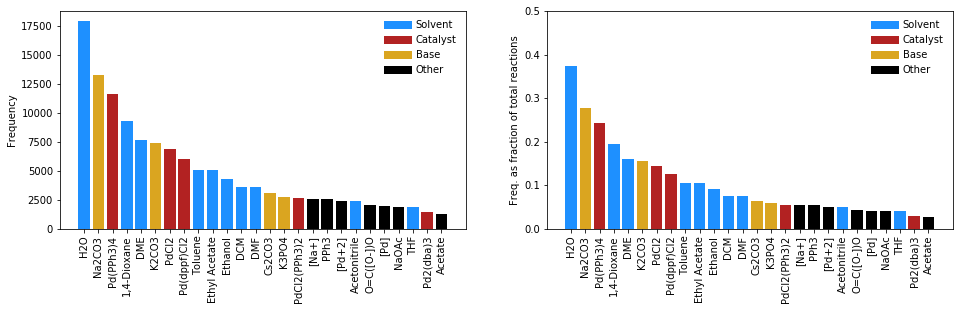

In [191]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

custom_lines = [Line2D([0], [0], color='dodgerblue', lw=8),
                Line2D([0], [0], color='firebrick', lw=8),
                Line2D([0], [0], color='goldenrod', lw=8),
                Line2D([0], [0], color='black', lw=8)]

solvents = ['H2O','1,4-Dioxane','DME','Ethyl Acetate','DMF','Toluene','DCM','Ethanol', 'THF', 'Acetonitrile']
catalysts = ['Pd(PPh3)4','PdCl2','Pd(dppf)Cl2','PdCl2(PPh3)2', 'Pd2(dba)3']
bases = ['Na2CO3','K2CO3', 'K3PO4', 'Cs2CO3']

fractions = [x/len(suzuki_data) for x in list(suzuki_rgt_dict_top15.values())]

i = 0
for k, v in suzuki_rgt_dict_top15.items():
    
    if k in solvents:
        col = 'dodgerblue'
    elif k in catalysts:
        col = 'firebrick'
    elif k in bases:
        col = 'goldenrod'
    else:
        col = 'black'
        
    ax[0].bar([i], [v], align='center', color=col)
    ax[1].bar([i], fractions[i], align='center', color=col)

    i += 1
    
for a in ax:
    a.set_xticks(np.arange(len(suzuki_rgt_dict_top15)))
    a.set_xticklabels(list(suzuki_rgt_dict_top15.keys()), rotation=90)
    a.legend(custom_lines, ['Solvent', 'Catalyst', 'Base', 'Other'], frameon=False)

ax[0].set_ylabel('Frequency')    
ax[1].set_ylabel('Freq. as fraction of total reactions')    
ax[1].set_yticks(np.arange(0, 0.55, 0.1))

plt.savefig('./suzuki.png', dpi=300, bbox_inches='tight')
plt.show()